In [1]:
import shapely
import shapely.wkt
import geopandas as gpd
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import warnings
import numpy as np
import seaborn as sns
warnings.filterwarnings("ignore")

from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from transform import calculate_distance_matrix, od_matrix_to_links, load_graph_geometry, get_accessibility_isochrone
from transform import dfs2nx
from ilp_solver import ilp_distribute
from dcgm import dcgm_distribute
from dcgm_custom import custom_dcgm_distribute

from tqdm.auto import tqdm
tqdm.pandas()

/var/essdata/IDU/venvs/common_venv/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
# territorial units
municipalities = gpd.read_file("data/mo.geojson")
blocks = gpd.read_file("data/blocks.geojson")

# houses and facilities
houses = gpd.read_file("data/houses.geojson").set_index("internal_id")
facilities = gpd.read_file("data/facilities_kindergartens.geojson").set_index("internal_id")

houses = houses.sjoin(municipalities).rename(columns={"id": "municipality_id"}).drop(["index_right"], axis=1)
facilities = facilities.sjoin(municipalities).rename(columns={"id": "municipality_id"}).drop(["index_right"], axis=1)

# road network
network = nx.read_graphml("data/road_network.graphml", node_type=int)
road_network = load_graph_geometry(network, node=True)

#### **Integer Linear Programming (ILP) and Doubly-Constrained Gravity Model (DCGM)**

In [3]:
# model population-facilties interactions with ILP

DM = calculate_distance_matrix(network, houses, facilities)
OD_ILP = ilp_distribute(houses, facilities, DM, selection_range=600)

  0%|          | 0/21464 [00:00<?, ?it/s]

Flows have been distributed.
Population left: 14753.0
Capacities left: 0.0


In [ ]:
# model population-facilties interactions with classic DCGM
# ! DOESN'T CONVERGE

OD_DCGM = dcgm_distribute(houses, facilities, DM)

In [4]:
#  model population-facilties interactions with custom DCGM

OD_СDCGM = custom_dcgm_distribute(houses, facilities, DM, 600, p=0)

100%|██████████| 9/9 [00:59<00:00,  6.59s/it]

Flows have been distributed.
Population left: 14753.0
Capacities left: 0.0


In [7]:
# merge results into dfs

dist = 600

houses["provision_ilp"] = OD_ILP[DM <= dist].fillna(0).sum() / houses["demand"]
houses["provision_dcgm"] = OD_СDCGM[DM <= dist].fillna(0).sum() / houses["demand"]
houses["supported_demand_ilp"] = OD_ILP[DM <= dist][houses.index].fillna(0).sum()
houses["supported_demand_dcgm"] = OD_СDCGM[DM <= dist][houses.index].fillna(0).sum()
houses["left_demand_ilp"] = houses["demand"] - houses["supported_demand_ilp"]
houses["left_demand_dcgm"] = houses["demand"] - houses["supported_demand_dcgm"]

facilities["left_capacity_ilp"] = facilities["capacity"] - OD_ILP[DM <= 600].fillna(0).sum(1)
facilities["left_capacity_dcgm"] = facilities["capacity"] - OD_СDCGM[DM <= 600].fillna(0).sum(1)

houses_aggr = houses.groupby(["municipality_id"]).sum()
municipalities = municipalities.join((houses_aggr["supported_demand_ilp"] / houses_aggr["demand"]).rename("provision_ilp"), on="id")
municipalities = municipalities.join((houses_aggr["supported_demand_dcgm"] / houses_aggr["demand"]).rename("provision_dcgm"), on="id")

edges_ilp = od_matrix_to_links(OD_ILP, DM, houses, facilities)
edges_dcgm = od_matrix_to_links(OD_СDCGM, DM, houses, facilities)

  0%|          | 0/21464 [00:00<?, ?it/s]

  0%|          | 0/21464 [00:00<?, ?it/s]

In [41]:
houses.to_file("output/houses.geojson")
facilities.to_file("output/facilities.geojson")
municipalities.to_file("output/mo_aggr.geojson")

edges_ilp.to_file("output/edges_ilp.geojson")
edges_dcgm.to_file("output/edges_dcgm.geojson")

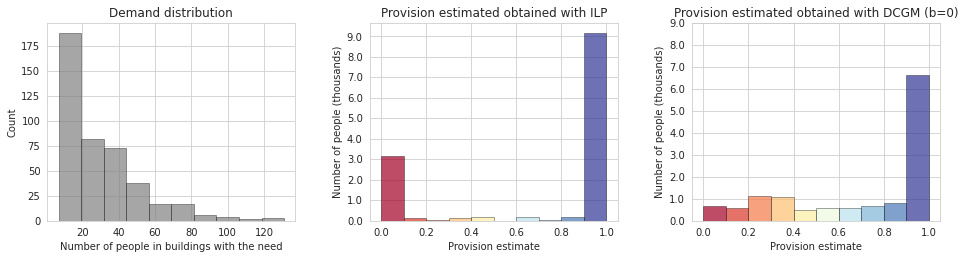

In [16]:
def set_color_map(bins, patches, color_palette):
    cm = plt.cm.get_cmap(color_palette)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    col = bin_centers - min(bin_centers)
    col /= max(col)

    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))

dist = 600
houses_loc = houses[houses["municipality_id"].isin([88, 72, 21])]

fig = plt.figure(figsize=(16, 8))
plt.subplots_adjust(wspace=0.3)
gs = fig.add_gridspec(2,3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

n, bins, patches = ax1.hist(houses_loc["demand"], 10, alpha = 0.7, color='grey', edgecolor='black', linewidth=0.5)
ax1.set_xlabel("Number of people in buildings with the need")
ax1.set_ylabel("Count")
ax1.set_title("Demand distribution")

ax2_n, bins, patches = ax2.hist(houses_loc["provision_ilp"], 10, alpha = 0.7, weights=houses_loc["demand"], edgecolor='black', linewidth=0.5)
set_color_map(bins, patches, "RdYlBu")
ax2.set_yticks(np.arange(0, max(ax2_n) + 1, 1000))
ax2.set_yticklabels([x / 1000 for x in ax2.get_yticks().tolist()])
ax2.set_xlabel("Provision estimate")
ax2.set_ylabel("Number of people (thousands)")
ax2.set_title("Provision estimated obtained with ILP")

ax3_n, bins, patches = ax3.hist(houses_loc["provision_dcgm"], 10, alpha = 0.7, weights=houses_loc["demand"], edgecolor='black', linewidth=0.5)
set_color_map(bins, patches, "RdYlBu")
ax3.set_yticks(np.arange(0, max(ax2_n)+1, 1000))
ax3.set_yticklabels([x / 1000 for x in ax3.get_yticks().tolist()])
ax3.set_xlabel("Provision estimate")
ax3.set_ylabel("Number of people (thousands)")
ax3.set_title("Provision estimated obtained with DCGM (b=0)")

plt.show()

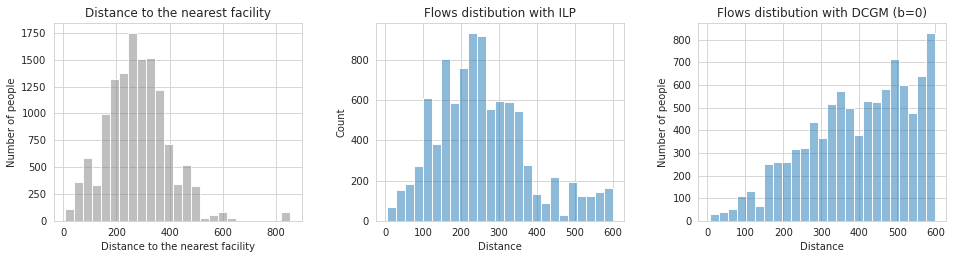

In [15]:
dist = 600
houses_loc = houses[houses["municipality_id"].isin([88, 72, 21])]

fig = plt.figure(figsize=(16, 8))
plt.subplots_adjust(wspace=0.3)
gs = fig.add_gridspec(2,3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

distances_dcgm = DM[OD_СDCGM > 0][houses_loc.index].to_numpy().flatten()
distances_dcgm = distances_dcgm[~np.isnan(distances_dcgm)]
flows_dcgm = OD_СDCGM[OD_СDCGM > 0][houses_loc.index].to_numpy().flatten()
flows_dcgm = flows_dcgm[~np.isnan(flows_dcgm)]

distances_ilp = DM[OD_ILP > 0][houses_loc.index].to_numpy().flatten()
distances_ilp = distances_ilp[~np.isnan(distances_ilp)]
flows_ilp = OD_ILP[OD_ILP > 0][houses_loc.index].to_numpy().flatten()
flows_ilp = flows_ilp[~np.isnan(flows_ilp)]

f_dist_nearest = pd.DataFrame({"distance": list(DM.min().loc[houses_loc.index]), "flows": houses["demand"].loc[houses_loc.index]})
f_dist_dcgm = pd.DataFrame({"distance": distances_dcgm[distances_dcgm<=600], "flows":flows_dcgm[distances_dcgm<=600]})
f_dist_ilp = pd.DataFrame({"distance": distances_ilp[distances_ilp<=600], "flows":flows_ilp[distances_ilp<=600]})

sns.histplot(data=f_dist_nearest, x="distance", bins=25, alpha = 0.5, ax=ax1, kde=False, color="gray", weights='flows')
ax1.set_title("Distance to the nearest facility")
ax1.set_xlabel("Distance to the nearest facility")
ax1.set_ylabel("Number of people")

sns.histplot(data=f_dist_ilp, x="distance", bins=25, alpha = 0.5, ax=ax2, kde=False, weights='flows')
ax2.set_title("Flows distibution with ILP")
ax2.set_xlabel("Distance")
ax3.set_ylabel("Number of people")

sns.histplot(data=f_dist_dcgm, x="distance", bins=25, alpha = 0.5, ax=ax3, kde=False, weights='flows')
ax3.set_title("Flows distibution with DCGM (b=0)")
ax3.set_xlabel("Distance")
ax3.set_ylabel("Number of people")

plt.show()

100%|██████████| 9/9 [00:58<00:00,  6.55s/it]


Flows have been distributed.
Population left: 14753.0
Capacities left: 0.0


100%|██████████| 9/9 [01:00<00:00,  6.68s/it]


Flows have been distributed.
Population left: 14753.0
Capacities left: 0.0


100%|██████████| 9/9 [00:57<00:00,  6.36s/it]


Flows have been distributed.
Population left: 14753.0
Capacities left: 0.0


100%|██████████| 9/9 [00:56<00:00,  6.22s/it]


Flows have been distributed.
Population left: 14753.0
Capacities left: 0.0


100%|██████████| 9/9 [00:55<00:00,  6.17s/it]


Flows have been distributed.
Population left: 14753.0
Capacities left: 0.0


100%|██████████| 9/9 [00:57<00:00,  6.37s/it]


Flows have been distributed.
Population left: 14753.0
Capacities left: 0.0


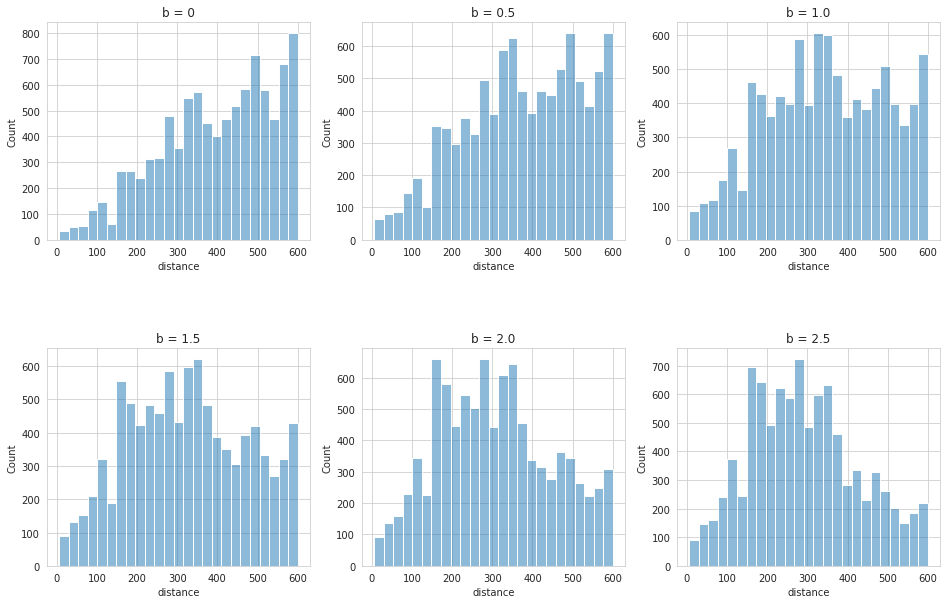

In [11]:
fig = plt.figure(figsize=(16, 10))
plt.subplots_adjust(hspace=0.5)
gs = fig.add_gridspec(2,3)
ax1 = fig.add_subplot(gs[0, 0])
ax4 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax5 = fig.add_subplot(gs[1, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax6 = fig.add_subplot(gs[1, 2])

p = 0

houses_loc = houses[houses["municipality_id"].isin([88, 72, 21])]
for i in range(1, 7):
    OD_СDCGM = custom_dcgm_distribute(houses, facilities, DM, 600, p=p)

    distances_dcgm = DM[OD_СDCGM > 0][houses_loc.index].to_numpy().flatten()
    distances_dcgm = distances_dcgm[~np.isnan(distances_dcgm)]
    flows_dcgm = OD_СDCGM[OD_СDCGM > 0][houses_loc.index].to_numpy().flatten()
    flows_dcgm = flows_dcgm[~np.isnan(flows_dcgm)]

    f_dist_dcgm = pd.DataFrame({"distance": distances_dcgm[distances_dcgm<=600], "flows":flows_dcgm[distances_dcgm<=600]})

    sns.histplot(data=f_dist_dcgm, x="distance", bins=25, alpha = 0.5, ax=locals()["ax" + str(i)], kde=False, weights='flows')
    locals()["ax" + str(i)].set_title("b = " + str(p))

    p += 0.5

plt.show()

  0%|          | 0/21464 [00:00<?, ?it/s]

  0%|          | 0/21464 [00:00<?, ?it/s]

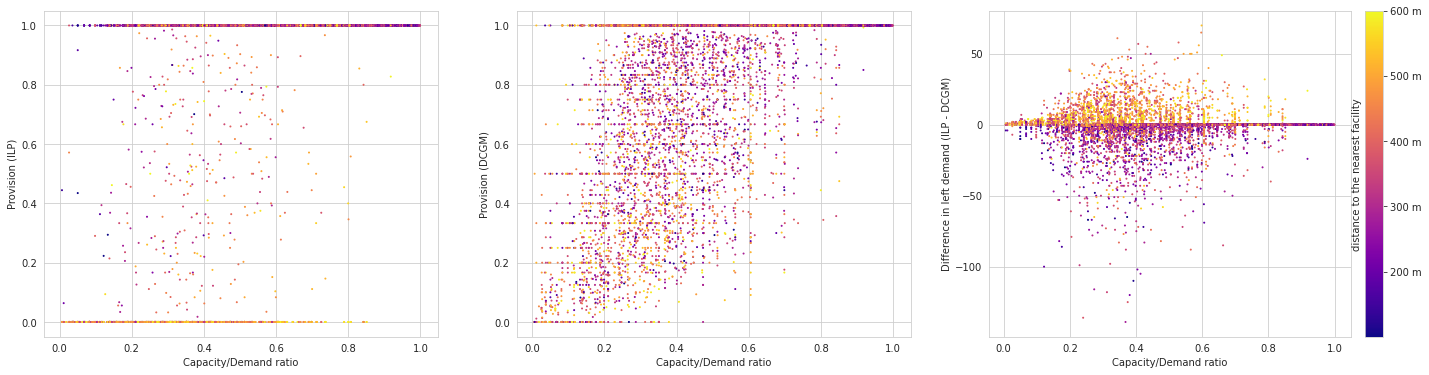

In [17]:
diff = houses["left_demand_ilp"] - houses["left_demand_dcgm"]

dm = (DM <= dist)
demand_around = dm.progress_apply(lambda x: houses['demand'][dm.loc[facilities["capacity"][x].index].any()].sum())
sum_capacity = dm.progress_apply(lambda x: facilities["capacity"][x].sum())
ratio = sum_capacity / demand_around

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))
color_palette = plt.cm.get_cmap("plasma")
distances = list(DM.min()[ratio < 1])
color_pointer = [i / max(distances) for i in distances]

ax1.set_xlabel("Capacity/Demand ratio")
ax1.set_ylabel("Provision (ILP)")
a = ax1.scatter(ratio[ratio < 1], houses["provision_ilp"][ratio < 1], c=color_pointer, cmap=color_palette, s=1)
# ax1.legend(handles=a.legend_elements()[0], labels=color_class)

ax2.set_xlabel("Capacity/Demand ratio")
ax2.set_ylabel("Provision (DCGM)")
b = ax2.scatter(ratio[ratio < 1], houses["provision_dcgm"][ratio < 1], c=color_pointer, cmap=color_palette, s=1)
# ax2.legend(handles=b.legend_elements()[0], labels=color_class)

ax3.set_xlabel("Capacity/Demand ratio")
ax3.set_ylabel("Difference in left demand (ILP - DCGM)")
c = ax3.scatter(ratio[ratio < 1], diff[ratio < 1], c=color_pointer, cmap=color_palette, s=1)

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.2)

cbar = fig.colorbar(a, cax=cax, orientation='vertical')
cbar.set_label("distance to the nearest facility", labelpad=-70)
cbar.set_ticklabels([str(d) + " m" for d in range(100, int(max(distances)) + 1, 100)])
# ax3.legend(handles=c.legend_elements()[0], labels=color_class)

In [18]:
# transform dfs to graphs networkx

ilp_graph = dfs2nx(DM, OD_ILP, houses, facilities, 600)
ilp_graph_components = [ilp_graph.subgraph(c).copy() for c in nx.connected_components(ilp_graph.to_undirected())]
dcgm_graph = dfs2nx(DM, OD_СDCGM, houses, facilities, 600)
dcgm_graph_components = [dcgm_graph.subgraph(c).copy() for c in nx.connected_components(dcgm_graph.to_undirected())]

  0%|          | 0/21464 [00:00<?, ?it/s]

  0%|          | 0/21464 [00:00<?, ?it/s]

In [ ]:
# to vizualize graph as geoobjects (nodes, links)

nodes_ilp = []
edges_ilp = []
for i, c in tqdm(enumerate(ilp_graph_components), total=len(ilp_graph_components)):
    gdf_nodes = gpd.GeoDataFrame.from_dict(dict(c.nodes(data=True)), orient='index')
    gdf_nodes['geometry'] = gdf_nodes['geometry'].apply(wkt.loads)
    gdf_nodes["component"] = i
    nodes_ilp.append(gdf_nodes)

    gdf_edges = nx.to_pandas_edgelist(c)
    gdf_edges["component"] = i
    gdf_edges["geometry"] = gdf_edges.apply(
        lambda x: shapely.geometry.LineString((gdf_nodes.geometry[x.source], gdf_nodes.geometry[x.target])),
        axis=1)
    edges_ilp.append(gdf_edges)

nodes_ilp = pd.concat(nodes_ilp)
edges_ilp = pd.concat(edges_ilp)

gpd.GeoDataFrame(edges_ilp).to_file("output/graph_edges_components.geojson", driver="GeoJSON")
gpd.GeoDataFrame(nodes_ilp).to_file("output/graph_nodes_components.geojson", driver="GeoJSON")

In [ ]:
# calculate 600 m walk isohrones 

facilities_loc = nodes_ilp[nodes_ilp["type"] == 0]
components = list(facilities_loc["component"].unique())
zones = []

limit = 600
edge_weight = "length_meter"
crs = 32636
for c in tqdm(components, total=len(components)):
    isochrones = []
    facilities_zone = facilities_loc[facilities_loc["component"] == c]

    for index, row in facilities_zone.iterrows():
        point = (row["geometry"].xy[0][0], row["geometry"].xy[1][0])
        isochrone = get_accessibility_isochrone(road_network, "walk", point[0], point[1], limit, edge_weight, crs)
        isochrones.append(isochrone)

    df_isochrones = pd.concat(isochrones)
    united_isochrones = gpd.GeoDataFrame({"geometry": [df_isochrones["geometry"].to_crs(32636).unary_union], "component": [c]})
    zones.append(united_isochrones)
    
isochrone_zones = pd.concat(zones).reset_index(drop=True)

##### **Neural net**

In [1]:
import numpy as np
import random
import json

from tensorboardX import SummaryWriter
from datetime import datetime
from torch_geometric.loader.dataloader import DataLoader
from tqdm.notebook import tqdm

from dataset import ProvisionSparseDataset_v2
from metrics import cross_validation

# torch.manual_seed(42)
# random.seed(42)
# np.random.seed(42)

/var/essdata/IDU/venvs/common_venv/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
dataset_ilp = ProvisionSparseDataset_v2("data/pyg_data/ilp")
dataset_dcgm = ProvisionSparseDataset_v2("data/pyg_data/dcgm/0")

In [ ]:
# train simple feedforward network

from vnn import FNN_v1, FNN_v2, train_func

datetime_now = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = "./logs/" + datetime_now
writer = SummaryWriter(logdir)
    
model_param_v2 = {
    "input_dim": 3, "hidden_dim_1": 64, "hidden_dim_2": 16, 
    "output_dim": 1, "num_layers": 4, "dropout": 0.20
    }

model_param_v1 = {
    "input_dim": 3, "hidden_dim": 64,
    "output_dim": 1, "num_layers": 4, "dropout": 0.20
    }
fnn_model_v1 = FNN_v1(**model_param_v1)
fnn_model_v2 = FNN_v2(**model_param_v2)

train_loader = DataLoader(dataset_ilp[25:], batch_size=len(dataset_ilp[25:]), shuffle=True)
valid_loader = DataLoader(dataset_ilp[:25], batch_size=len(dataset_ilp[:25]), shuffle=True)
flow_model = train_func(fnn_model_v2, train_loader, valid_loader, 5000, writer, output=True)

In [ ]:
# train stack gnn + fnn

import gnn

datetime_now = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = "./logs/" + datetime_now
writer = SummaryWriter(logdir)

gnn_param_v1 ={"input_dim":2, "hidden_dim": 32, "dropout": 0.25}

fnn_param_v1 = {
    "input_dim": 32 * 2 + 5, "hidden_dim": 64,
    "output_dim": 1, "num_layers": 4, "dropout": 0.30
    }

fnn_param_v3 = {
    "input_dim": 32 * 2 + 5, "hidden_dim_1": 64, "hidden_dim_2": 64,
    "output_dim": 1, "num_layers": 2, "num_layers_norm": 1, "dropout": 0.20
    }

gnn_model = gnn.GNNStack(**gnn_param_v1)
fnn_model = gnn.FNNStack_v3(**fnn_param_v3)

dataset_dcgm  = dataset_dcgm.shuffle()
train_loader = DataLoader(dataset_dcgm[25:], batch_size=len(dataset_dcgm[25:]), shuffle=True)
valid_loader = DataLoader(dataset_dcgm[:25], batch_size=len(dataset_dcgm[:25]), shuffle=True)
flow_model = gnn.train_func(gnn_model, fnn_model, train_loader, valid_loader, 500, writer, output=True)

In [5]:
# cross validation

import gnn

output = "output/metrics/metrics_dcgm_norm_layers.json"

gnn_param ={"input_dim":2, "hidden_dim": 32, "dropout": 0.25}
fnn_param_v1 = {"input_dim": 32 * 2 + 5, "hidden_dim": 64, "output_dim": 1, "num_layers": 4, "dropout": 0.20}
fnn_param_v3 = {"input_dim": 32 * 2 + 5, "hidden_dim_1": 64, "hidden_dim_2": 64, "output_dim": 1, "num_layers": 2, 
                "num_layers_norm": 0, "dropout": 0.20}

vnn_models = {"gnn_vnn_v3": [gnn.FNNStack_v3, fnn_param_v3]}

collected_metrics = []
for i in tqdm(range(5)):

    fnn_param_v3["num_layers_norm"] += 1 
    dataset = dataset_dcgm
    # dataset = dataset_dcgm.shuffle()
    for model_name, model in vnn_models.items():

        print(model_name)
        vnn_model, vnn_param = model

        metrics = cross_validation(
            dataset=dataset, 
            num_folds=5, 
            model_type="gnn+fnn", 
            model=[gnn.GNNStack, vnn_model], 
            model_param=[gnn_param, vnn_param], 
            train_func=gnn.train_func, 
            val_func=gnn.val_func, 
            logs=True, 
            epochs=500
            )
        
        collected_metrics.append(metrics)
        with open(output, 'r+') as file:
            file_data = json.load(file)
            
            if i not in file_data[model_name].keys():
                file_data[model_name].update({str(i): metrics})
                file.seek(0)
                json.dump(file_data, file)
            else:
                raise ValueError("The record with this key is already exists")

        print(metrics)

  0%|          | 0/5 [00:00<?, ?it/s]

gnn_vnn_v3


  0%|          | 0/5 [00:00<?, ?it/s]

In [22]:
with open("output/metrics/metrics_dcgm.json", 'r+') as file:
    file_data = json.load(file)

In [25]:
file_data["gnn_vnn_v1"]['2'], file_data["gnn_vnn_v2"]['2']

({'in-sample loss': [4.9617, 5.3839, 5.3068, 4.9645, 7.4336],
  'in-sample R2': [0.883, 0.8774, 0.8785, 0.8786, 0.8673],
  'out-of-sample loss': [9.4048, 6.994, 9.073, 11.4038, 2.5338],
  'out-of-sample R2': [0.8384, 0.8612, 0.826, 0.8171, 0.8689]},
 {'in-sample loss': [3.8148, 3.3602, 3.2208, 3.2374, 4.8797],
  'in-sample R2': [0.9101, 0.9235, 0.9262, 0.9208, 0.9129],
  'out-of-sample loss': [5.7784, 4.2957, 4.3062, 6.2789, 1.9591],
  'out-of-sample R2': [0.9007, 0.9148, 0.9174, 0.8993, 0.8987]})

In [23]:
file_data["gnn_vnn_v1"]['1'], file_data["gnn_vnn_v2"]['1']

({'in-sample loss': [5.5145, 5.1093, 8.2774, 5.7031, 5.266],
  'in-sample R2': [0.8744, 0.8862, 0.8589, 0.8627, 0.8684],
  'out-of-sample loss': [8.5727, 6.5922, 3.9671, 10.086, 13.2772],
  'out-of-sample R2': [0.8407, 0.8582, 0.8418, 0.8571, 0.8232]},
 {'in-sample loss': [3.117, 4.0196, 4.8089, 3.479, 3.6987],
  'in-sample R2': [0.929, 0.9105, 0.918, 0.9162, 0.9075],
  'out-of-sample loss': [4.4734, 4.2378, 3.0093, 6.9369, 8.2422],
  'out-of-sample R2': [0.9169, 0.9088, 0.88, 0.9017, 0.8902]})

In [21]:
dict((k, np.mean(v))for k, v in file_data["gnn_vnn_v1"]['2'].items()), dict((k, np.mean(v))for k, v in file_data["gnn_vnn_v2"]['2'].items())

({'in-sample loss': 5.821599999999999,
  'in-sample R2': 0.87074,
  'out-of-sample loss': 7.232139999999999,
  'out-of-sample R2': 0.84734},
 {'in-sample loss': 4.79172,
  'in-sample R2': 0.8940199999999999,
  'out-of-sample loss': 6.0206,
  'out-of-sample R2': 0.8699399999999999})